In [4]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
# from dataset import KaggleDataset
import torchvision.transforms.functional as tx
from model import YOLOv1
from loss import Loss
import cv2
import os
import numpy as np
import math
from datetime import datetime
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.tensorboard import SummaryWriter

In [5]:
few_data = False
data_num = 3000

In [6]:
init_lr = 0.001
base_lr = 0.01
momentum = 0.9
weight_decay = 5.0e-4
num_epochs = 135
batch_size = 25

In [7]:
# dir = os.listdir("../../../DL_data/competition2/datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages")
# print(dir)

In [8]:
image_dir = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages"

# Path to label files.
train_label = '../data/train.txt'
valid_label = '../data/valid.txt'

In [9]:
class MyDataset():

    def __init__(self, augment, image_dir, label_txt, image_size=448, grid_size=7, num_bboxes=2, num_classes=20):
        self.image_size = image_size
        self.augment = augment
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes
        self.cach={}
        mean_rgb = [114.40881884832626, 108.43621239448395, 100.02786994986522]
        std_rgb=[61.16924025123464, 59.74685629314272, 60.37084580490068]
        self.mean = np.array(mean_rgb, dtype=np.float32)
        self.std = np.array(std_rgb, dtype=np.float32)
        count = 0
#         self.to_tensor = transforms.ToTensor()
        self.paths, self.boxes, self.labels = [], [], []
        with open(label_txt) as f:
            lines = f.readlines()
        
        for line in lines:
            splitted = line.strip().split()

            fname = splitted[0]
            path = os.path.join(image_dir, fname)
            self.paths.append(path)

            num_boxes = (len(splitted) - 1) // 5
            box, label = [], []
            for i in range(num_boxes):
                x1 = float(splitted[5*i + 1])
                y1 = float(splitted[5*i + 2])
                x2 = float(splitted[5*i + 3])
                y2 = float(splitted[5*i + 4])
                c  =   int(splitted[5*i + 5])
                box.append([x1, y1, x2, y2])
                label.append(c)
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
            count+=1
#             if few_data:
#                 if count==data_num:
#                     break

        self.num_samples = len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = self.cach[path]
        except:
            img = cv2.imread(path)
            self.cach[path] = img
        boxes = self.boxes[idx].clone() # [n, 4]
        labels = self.labels[idx].clone() # [n,]

        if self.augment:

            img, boxes = self.random_flip_lr(img, boxes)
            img, boxes = self.random_flip_ud(img, boxes)
            img, boxes = self.random_scale(img, boxes)
            img = self.random_blur(img)
            img = self.random_brightness(img)
            img = self.random_hue(img)
            img = self.random_saturation(img)
            img = self.random_noise(img)
            img, boxes, labels = self.random_shift(img, boxes, labels)
            img, boxes, labels = self.random_crop(img, boxes, labels)

        h, w, _ = img.shape
        boxes /= torch.Tensor([[w, h, w, h]]).expand_as(boxes) # normalize (x1, y1, x2, y2) w.r.t. image width/height.
        target = self.encode(boxes, labels) # [S, S, 5 x B + C]

        img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is pretrained with RGB images.
        img = (img - self.mean) / self.std # normalize from -1.0 to 1.0.

        img = tx.to_tensor(img)
        
        return (img, target)

    def __len__(self):
        return self.num_samples
    def random_noise(self, img):
        if random.random() < 0.5:
            return img

        mean = 0
        sigma = 0.1

        noise = np.random.normal(mean, sigma, img.shape)
        noise = (noise*255)
        noise = noise.astype(np.uint8)
        img = img + noise

        return img
    def random_flip_lr(self, img, boxes):
        if random.random() < 0.5:
            return img, boxes
#         print("flip")
        h, w, _ = img.shape

        img = np.fliplr(img)

        x1, x2 = boxes[:, 0], boxes[:, 2]
        x1_new = w - x2
        x2_new = w - x1
        boxes[:, 0], boxes[:, 2] = x1_new, x2_new

        return img, boxes
    def random_flip_ud(self, img, boxes):
        
        if random.random() < 0.5:
            return img, boxes
#         print("flip")
        h, w, _ = img.shape

        img = np.flipud(img)

        y1, y2 = boxes[:, 1], boxes[:, 3]
        y1_new = h - y2
        y2_new = h - y1
        boxes[:, 1], boxes[:, 3] = y1_new, y2_new

        return img, boxes


    def random_scale(self, img, boxes):
        if random.random() < 0.5:
            return img, boxes
#         print("scale")
        scale = random.uniform(0.8, 1.2)
        h, w, _ = img.shape
        img = cv2.resize(img, dsize=(int(w * scale), h), interpolation=cv2.INTER_LINEAR)

        scale_tensor = torch.FloatTensor([[scale, 1.0, scale, 1.0]]).expand_as(boxes)
        boxes = boxes * scale_tensor

        return img, boxes

    def random_blur(self, bgr):
        if random.random() < 0.5:
            return bgr
#         print("blur")
        ksize = random.choice([2, 3, 4, 5])
        bgr = cv2.blur(bgr, (ksize, ksize))
        return bgr

    def random_brightness(self, bgr):
        if random.random() < 0.5:
            return bgr
#         print("brightness")
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        adjust = random.uniform(0.5, 1.5)
        v = v * adjust
        v = np.clip(v, 0, 255).astype(hsv.dtype)
        hsv = cv2.merge((h, s, v))
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return bgr

    def random_hue(self, bgr):
        if random.random() < 0.5:
            return bgr

        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        adjust = random.uniform(0.8, 1.2)
        h = h * adjust
        h = np.clip(h, 0, 255).astype(hsv.dtype)
        hsv = cv2.merge((h, s, v))
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return bgr

    def random_saturation(self, bgr):
        if random.random() < 0.5:
            return bgr
#         print("saturation")
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        adjust = random.uniform(0.5, 1.5)
        s = s * adjust
        s = np.clip(s, 0, 255).astype(hsv.dtype)
        hsv = cv2.merge((h, s, v))
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return bgr
    def random_shift(self, img, boxes, labels):
        if random.random() < 0.5:
            return img, boxes, labels

        center = (boxes[:, 2:] + boxes[:, :2]) / 2.0

        h, w, c = img.shape
        img_out = np.zeros((h, w, c), dtype=img.dtype)
        mean_bgr = self.mean[::-1]
        img_out[:, :] = mean_bgr

        dx = random.uniform(-w*0.2, w*0.2)
        dy = random.uniform(-h*0.2, h*0.2)
        dx, dy = int(dx), int(dy)

        if dx >= 0 and dy >= 0:
            img_out[dy:, dx:] = img[:h-dy, :w-dx]
        elif dx >= 0 and dy < 0:
            img_out[:h+dy, dx:] = img[-dy:, :w-dx]
        elif dx < 0 and dy >= 0:
            img_out[dy:, :w+dx] = img[:h-dy, -dx:]
        elif dx < 0 and dy < 0:
            img_out[:h+dy, :w+dx] = img[-dy:, -dx:]

        center = center + torch.FloatTensor([[dx, dy]]).expand_as(center) # [n, 2]
        mask_x = (center[:, 0] >= 0) & (center[:, 0] < w) # [n,]
        mask_y = (center[:, 1] >= 0) & (center[:, 1] < h) # [n,]
        mask = (mask_x & mask_y).view(-1, 1) # [n, 1], mask for the boxes within the image after shift.

        boxes_out = boxes[mask.expand_as(boxes)].view(-1, 4) # [m, 4]
        if len(boxes_out) == 0:
            return img, boxes, labels
        shift = torch.FloatTensor([[dx, dy, dx, dy]]).expand_as(boxes_out) # [m, 4]

        boxes_out = boxes_out + shift
        boxes_out[:, 0] = boxes_out[:, 0].clamp_(min=0, max=w)
        boxes_out[:, 2] = boxes_out[:, 2].clamp_(min=0, max=w)
        boxes_out[:, 1] = boxes_out[:, 1].clamp_(min=0, max=h)
        boxes_out[:, 3] = boxes_out[:, 3].clamp_(min=0, max=h)

        labels_out = labels[mask.view(-1)]

        return img_out, boxes_out, labels_out

    def random_crop(self, img, boxes, labels):
        if random.random() < 0.5:
            return img, boxes, labels
#         print("crop")
        center = (boxes[:, 2:] + boxes[:, :2]) / 2.0

        h_orig, w_orig, _ = img.shape
        h = random.uniform(0.6 * h_orig, h_orig)
        w = random.uniform(0.6 * w_orig, w_orig)
        y = random.uniform(0, h_orig - h)
        x = random.uniform(0, w_orig - w)
        h, w, x, y = int(h), int(w), int(x), int(y)

        center = center - torch.FloatTensor([[x, y]]).expand_as(center) # [n, 2]
        mask_x = (center[:, 0] >= 0) & (center[:, 0] < w) # [n,]
        mask_y = (center[:, 1] >= 0) & (center[:, 1] < h) # [n,]
        mask = (mask_x & mask_y).view(-1, 1) # [n, 1], mask for the boxes within the image after crop.

        boxes_out = boxes[mask.expand_as(boxes)].view(-1, 4) # [m, 4]
        if len(boxes_out) == 0:
            return img, boxes, labels
        shift = torch.FloatTensor([[x, y, x, y]]).expand_as(boxes_out) # [m, 4]

        boxes_out = boxes_out - shift
        boxes_out[:, 0] = boxes_out[:, 0].clamp_(min=0, max=w)
        boxes_out[:, 2] = boxes_out[:, 2].clamp_(min=0, max=w)
        boxes_out[:, 1] = boxes_out[:, 1].clamp_(min=0, max=h)
        boxes_out[:, 3] = boxes_out[:, 3].clamp_(min=0, max=h)

        labels_out = labels[mask.view(-1)]
        img_out = img[y:y+h, x:x+w, :]

        return img_out, boxes_out, labels_out
    
    def encode(self, boxes, labels):
        """ Encode box coordinates and class labels as one target tensor.
        Args:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...], normalized from 0.0 to 1.0 w.r.t. image width/height.
            labels: (tensor) [c_obj1, c_obj2, ...]
        Returns:
            An encoded tensor sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        """

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C

        target = torch.zeros(S, S, N)
        cell_size = 1.0 / float(S)
        boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
        boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]
        for b in range(boxes.size(0)):
            xy, wh, label = boxes_xy[b], boxes_wh[b], int(labels[b])

            ij = (xy / cell_size).ceil() - 1.0
            i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
            x0y0 = ij * cell_size # x & y of the cell left-top corner.
            xy_normalized = (xy - x0y0) / cell_size # x & y of the box on the cell, normalized from 0.0 to 1.0.

            # TBM, remove redundant dimensions from target tensor.
            # To remove these, loss implementation also has to be modified.
            for k in range(B):
                s = 5 * k
                target[j, i, s  :s+2] = xy_normalized
                target[j, i, s+2:s+4] = wh
                target[j, i, s+4    ] = 1.0
            target[j, i, 5*B + label] = 1.0
        return target

    

In [10]:
sampler_prob = pd.read_csv("train_sampler.csv")
weights = sampler_prob["prob"]
sampler = torch.utils.data.WeightedRandomSampler(weights,data_num)
train_dataset = MyDataset(True, image_dir, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = sampler)

valid_dataset = MyDataset(False, image_dir, valid_label)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(valid_loader))

120
40


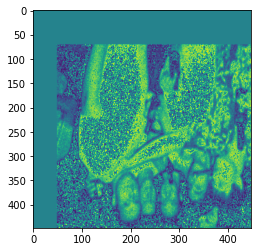

In [11]:
image, target = next(iter(train_loader))
plt.imshow(image[0][0])

In [12]:
def train(train_loader, yolo, optmizer, criterion,epoch):
    yolo.train()
    total_loss = 0
    total_batch = 0
    for i, (imgs, targets) in enumerate(train_loader):
        # Update learning rate.
#         update_lr(optimizer, epoch, float(i) / float(len(train_loader) - 1))
#         lr = get_lr(optimizer)
        # Load data as a batch.
        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()
#         print(imgs.shape)
#         print(targets.shape)
#         plt.imshow(imgs[0][0].cpu().detach().numpy())
        # Forward to compute loss.
        preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        total_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter

        # Backward to update model weight.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss
        # Print current loss.
        

In [13]:
def valid(valid_loader, yolo):
    yolo.eval()
    val_loss = 0.0
    total_batch = 0

    for i, (imgs, targets) in enumerate(valid_loader):
        # Load data as a batch.
        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()

        # Forward to compute validation loss.
        with torch.no_grad():
            preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        val_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter
#     val_loss /= float(total_batch)
    return val_loss

In [14]:
model_conv = torchvision.models.vgg19(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
print(model_conv)
model_conv = nn.Sequential(*(list(model_conv.children())[:-2]))
yolo = YOLOv1(model_conv)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
criterion = Loss(feature_size=yolo.feature_size)
origin_lr = 0.001
optimizer = torch.optim.SGD(yolo.parameters(), lr=origin_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
resume_date="11_14_1"
yolo.load_state_dict(torch.load("../data/model/"+resume_date+"/best_Loss_model.pth"))
yolo.to("cuda")
date = "11_15_1"
# date="test"
writer = SummaryWriter("runs/"+date)
min_loss = 10000
not_improve = 0
lr = origin_lr
save_frequency = 0
if not os.path.exists("../data/model"):
    os.mkdir("../data/model")
if not os.path.exists("../data/model/"+date):
    os.mkdir("../data/model/"+date)
min_MSE = 10000
for i in range(500):
    print("epoch : ",i)
    total_loss = train(train_loader, yolo, optimizer, criterion,i)
    valid_loss = valid(valid_loader, yolo)
    save_frequency+=1
#     print(save_frequency)
#     print(min_loss, total_loss/len(train_loader))
    if save_frequency >= 10 :
        train_precision_score = train_score(yolo)
        valid_precision_score = valid_score(yolo)
        print("train MSE : ",train_precision_score)
        print("valid MSE : ",valid_precision_score)
        writer.add_scalar("MSE/train", train_precision_score, i)
        writer.add_scalar("MSE/valid", valid_precision_score, i)
        if min_MSE > valid_precision_score:
            min_MSE = valid_precision_score
            torch.save(yolo.state_dict(), "../data/model/"+date+"/best_MSE_model.pth")
            print("@@@@@@@@@@@@@save best MSE model@@@@@@@@@@@@@@@@@@@")
        save_frequency = 0
    print("train loss :",total_loss/(len(train_loader)*batch_size))
    print("valid loss :",valid_loss/(len(valid_loader)*batch_size))
    writer.add_scalar("Loss/train", total_loss/(len(train_loader)*batch_size), i)
    writer.add_scalar("Loss/valid", valid_loss/(len(valid_loader)*batch_size), i)
    writer.add_scalar("learning rate", lr, i)
    if min_loss>valid_loss/(len(valid_loader)*batch_size):
        min_loss = valid_loss/(len(valid_loader)*batch_size)
        not_improve = 0
        torch.save(yolo.state_dict(), "../data/model/"+date+"/best_Loss_model.pth")
        print("@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@")
    else:
        not_improve+=1
        if not_improve==30:
            print("############reduce lr#############")
            not_improve = 0
            lr/=2
            for g in optimizer.param_groups:
                g['lr'] = lr

epoch :  0


C:\Users\HMILAB\Desktop\Tony\deep_learning\Competition2\code\loss.py:102: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
C:\Users\HMILAB\Desktop\Tony\deep_learning\Competition2\code\loss.py:103: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])]
C:\Users\HMILAB\Desktop\Tony\deep_learning\Competition2\code\loss.py:141: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C

train loss : 5.217928105592728
valid loss : 3.578021491765976
@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@
epoch :  1
train loss : 5.264860651890436
valid loss : 3.60599564909935
epoch :  2
train loss : 5.308679749568303
valid loss : 3.581448349952698
epoch :  3
train loss : 5.1836542348066965
valid loss : 3.5409174358844755
@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@
epoch :  4
train loss : 5.2814248939355215
valid loss : 3.5527733898162843
epoch :  5
train loss : 5.2149955113728845
valid loss : 3.578648656606674
epoch :  6
train loss : 5.203624647855759
valid loss : 3.5702320981025695
epoch :  7
train loss : 5.186417382955551
valid loss : 3.5685773050785063
epoch :  8
train loss : 5.283886247873307
valid loss : 3.5716880023479463
epoch :  9
train MSE :  0.5349226662852925
valid MSE :  0.6282430006466917
@@@@@@@@@@@@@save best MSE model@@@@@@@@@@@@@@@@@@@
train loss : 5.135383633772532
valid loss : 3.607519855499268
epoch :  10
train loss : 5.237027225891749
valid los

In [1]:
def decode(pred_tensor):
        """ Decode tensor into box coordinates, class labels, and probs_detected.
        Args:
            pred_tensor: (tensor) tensor to decode sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        Returns:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...]. Normalized from 0.0 to 1.0 w.r.t. image width/height, sized [n_boxes, 4].
            labels: (tensor) class labels for each detected boxe, sized [n_boxes,].
            confidences: (tensor) objectness confidences for each detected box, sized [n_boxes,].
            class_scores: (tensor) scores for most likely class for each detected box, sized [n_boxes,].
        """
        conf_thresh = 0
        prob_thresh = 0
        nms_thresh = 0.45
        S, B, C = 7, 2, 20
        boxes, labels, confidences, class_scores = [], [], [], []

        cell_size = 1.0 / float(S)

        conf = pred_tensor[:, :, 4].unsqueeze(2) # [S, S, 1]
        for b in range(1, B):
            conf = torch.cat((conf, pred_tensor[:, :, 5*b + 4].unsqueeze(2)), 2)
        conf_mask = conf > conf_thresh # [S, S, B]

        # TBM, further optimization may be possible by replacing the following for-loops with tensor operations.
        for i in range(S): # for x-dimension.
            for j in range(S): # for y-dimension.
                class_score, class_label = torch.max(pred_tensor[j, i, 5*B:], 0)

                for b in range(B):
                    conf = pred_tensor[j, i, 5*b + 4]
                    prob = conf * class_score
                    if float(prob) < prob_thresh:
                        continue

                    # Compute box corner (x1, y1, x2, y2) from tensor.
                    box = pred_tensor[j, i, 5*b : 5*b + 4]
                    x0y0_normalized = torch.FloatTensor([i, j]) * cell_size # cell left-top corner. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    xy_normalized = box[:2] * cell_size + x0y0_normalized   # box center. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    wh_normalized = box[2:] # Box width and height. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    box_xyxy = torch.FloatTensor(4) # [4,]
                    box_xyxy[:2] = xy_normalized - 0.5 * wh_normalized # left-top corner (x1, y1).
                    box_xyxy[2:] = xy_normalized + 0.5 * wh_normalized # right-bottom corner (x2, y2).
                    box_xyxy[:2] *= 448 
                    box_xyxy[2:] *= 448
                    # Append result to the lists.
                    boxes.append(box_xyxy)
                    labels.append(class_label)
                    confidences.append(conf)
                    class_scores.append(class_score)

        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0) # [n_boxes, 4]
            labels = torch.stack(labels, 0)             # [n_boxes, ]
            confidences = torch.stack(confidences, 0)   # [n_boxes, ]
            class_scores = torch.stack(class_scores, 0) # [n_boxes, ]
        else:
            # If no box found, return empty tensors.
            boxes = torch.FloatTensor(0, 4)
            labels = torch.LongTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)

        return boxes, labels, confidences, class_scores

In [2]:
def valid_score(yolo):
#     yolo.load_state_dict(torch.load("../data/model/best_model.pth"))
    yolo.eval()
    pre_path = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/"
    test_img_files = open("../data/valid.txt")
    test_img_dir = pre_path+'VOCdevkit_train/VOC2007/JPEGImages/'
    test_images = []
    mean_rgb = [122.67891434, 116.66876762, 104.00698793]
    mean = np.array(mean_rgb, dtype=np.float32)
    image_size=448
    output_file = open('./valid_prediction.txt', 'w')
    count = 0
    yolo.to("cuda")
    for line in test_img_files:
#         if count%500==0:
#             print(count)
        line = line.strip()
        ss = line.split(' ')
        img = cv2.imread(test_img_dir+ss[0])
        origin_shape = img.shape
    #     print(origin_shape)
        x_ratio = origin_shape[1]/image_size
        y_ratio = origin_shape[0]/image_size
    #     print(x_ratio, y_ratio)
        img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is pretrained with RGB images.
        img = (img - mean) / 255.0 # normalize from -1.0 to 1.0.
        img = tx.to_tensor(img)
        img = img.to("cuda")
        img = img.reshape((1,3,image_size,image_size))

        prediction = yolo(img)
        prediction = prediction.to("cpu")

        decode_pred = decode(prediction[0])
    #     print(decode_pred)
    #     print(len(decode_pred[0]))
        for i in range(len(decode_pred[0])):
    #     for i in range(5):
    #         x_min = min(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
    #         x_max = max(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
    #         y_min = min(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
    #         y_max = max(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
            decode_pred[0][i][0]=int(x_ratio*decode_pred[0][i][0])
            decode_pred[0][i][2]=int(x_ratio*decode_pred[0][i][2])
            decode_pred[0][i][1]=int(y_ratio*decode_pred[0][i][1])
            decode_pred[0][i][3]=int(y_ratio*decode_pred[0][i][3])
    #     print(decode_pred)
        s=ss[0]+" "
        for i in range(len(decode_pred[0])):
    #     for i in range(5):
            if decode_pred[2][i]<0.1:
                continue
            for j in range(4):
                s+=str(decode_pred[0][i][j].item())+" "
            s+=str(decode_pred[1][i].item())+" "
            s+=str(decode_pred[2][i].item())+" "
        s+="\n"
        output_file.write(s)
        count+=1
        if few_data:
            if count==data_num:
                break
    #     break
    output_file.close()
    import sys
    sys.path.insert(0, pre_path+'./evaluate')
    import evaluate_valid
    #evaluate.evaluate("input prediction file name", "desire output csv file name")
    evaluate_valid.evaluate('./valid_prediction.txt', './valid_output_file.csv', "valid", "../data/valid.txt")
    valid_csv = pd.read_csv("valid_output_file.csv")
    MSE = 0
    for i in range(len(valid_csv["packedCAP"])):
        MSE+=(1-valid_csv["packedCAP"][i])**2
    return MSE/20

In [3]:
def train_score(yolo):
#     yolo.load_state_dict(torch.load("../data/model/best_model.pth"))
    yolo.eval()
    pre_path = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/"
    test_img_files = open("../data/train.txt")
    test_img_dir = pre_path+'VOCdevkit_train/VOC2007/JPEGImages/'
    test_images = []
    mean_rgb = [122.67891434, 116.66876762, 104.00698793]
    mean = np.array(mean_rgb, dtype=np.float32)
    image_size=448
    output_file = open('./train_prediction.txt', 'w')
    count = 0
    yolo.to("cuda")
    for line in test_img_files:
#         if count%500==0:
#             print(count)
        line = line.strip()
        ss = line.split(' ')
        img = cv2.imread(test_img_dir+ss[0])
        origin_shape = img.shape
    #     print(origin_shape)
        x_ratio = origin_shape[1]/image_size
        y_ratio = origin_shape[0]/image_size
    #     print(x_ratio, y_ratio)
        img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is pretrained with RGB images.
        img = (img - mean) / 255.0 # normalize from -1.0 to 1.0.
        img = tx.to_tensor(img)
        img = img.to("cuda")
        img = img.reshape((1,3,image_size,image_size))

        prediction = yolo(img)
        prediction = prediction.to("cpu")

        decode_pred = decode(prediction[0])
    #     print(decode_pred)
    #     print(len(decode_pred[0]))
        for i in range(len(decode_pred[0])):
    #     for i in range(5):
    #         x_min = min(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
    #         x_max = max(int(x_ratio*decode_pred[0][i][0]), int(x_ratio*decode_pred[0][i][2]))
    #         y_min = min(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
    #         y_max = max(int(y_ratio*decode_pred[0][i][1]), int(y_ratio*decode_pred[0][i][3]))
            decode_pred[0][i][0]=int(x_ratio*decode_pred[0][i][0])
            decode_pred[0][i][2]=int(x_ratio*decode_pred[0][i][2])
            decode_pred[0][i][1]=int(y_ratio*decode_pred[0][i][1])
            decode_pred[0][i][3]=int(y_ratio*decode_pred[0][i][3])
    #     print(decode_pred)
        s=ss[0]+" "
        for i in range(len(decode_pred[0])):
    #     for i in range(5):
            if decode_pred[2][i]<0.1:
                continue
            for j in range(4):
                s+=str(decode_pred[0][i][j].item())+" "
            s+=str(decode_pred[1][i].item())+" "
            s+=str(decode_pred[2][i].item())+" "
        s+="\n"
        output_file.write(s)
        count+=1
        if few_data:
            if count==data_num:
                break
    #     break
    output_file.close()
    import sys
    sys.path.insert(0, pre_path+'./evaluate')
    import evaluate_valid
    #evaluate.evaluate("input prediction file name", "desire output csv file name")
    evaluate_valid.evaluate('./train_prediction.txt', './train_output_file.csv', "train", "../data/train.txt")
    train_csv = pd.read_csv("train_output_file.csv")
    MSE = 0
    for i in range(len(train_csv["packedCAP"])):
        MSE+=(1-train_csv["packedCAP"][i])**2
    return MSE/20

In [21]:
decode_pred[1][49]

NameError: name 'decode_pred' is not defined

In [22]:
decode_pred[2][49]

NameError: name 'decode_pred' is not defined

In [23]:
prediction[0]

NameError: name 'prediction' is not defined

In [144]:
pre_path = "../../../DL_data/competition2/datalab-2021-cup2-object-detection/"
yolo.load_state_dict(torch.load("../data/model/best_model.pth"))
test_img_files = open(pre_path+'pascal_voc_testing_data.txt')
test_img_dir = pre_path+'VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
mean_rgb = [122.67891434, 116.66876762, 104.00698793]
mean = np.array(mean_rgb, dtype=np.float32)
image_size=448
output_file = open('./test_prediction.txt', 'w')
count = 0
for line in test_img_files:
    if count%500==0:
        print(count)
    line = line.strip()
    ss = line.split(' ')
    img = cv2.imread(test_img_dir+ss[0])
    origin_shape = img.shape
#     print(origin_shape)
    x_ratio = origin_shape[1]/image_size
    y_ratio = origin_shape[0]/image_size
#     print(x_ratio, y_ratio)
    img = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is pretrained with RGB images.
    img = (img - mean) / 255.0 # normalize from -1.0 to 1.0.
    img = tx.to_tensor(img)
    img = img.to("cuda")
    img = img.reshape((1,3,image_size,image_size))
    prediction = yolo(img)
    prediction = prediction.to("cpu")
    decode_pred = decode(prediction[0])
#     print(decode_pred)
#     for i in range(len(decode_pred[0])):
    for i in range(5):
        decode_pred[0][i][0]=int(x_ratio*decode_pred[0][i][0])
        decode_pred[0][i][2]=int(x_ratio*decode_pred[0][i][2])
        decode_pred[0][i][1]=int(y_ratio*decode_pred[0][i][1])
        decode_pred[0][i][3]=int(y_ratio*decode_pred[0][i][3])
#     print(decode_pred)
    s=ss[0]+" "
    for i in range(len(decode_pred[0])):
        for j in range(4):
            s+=str(decode_pred[0][i][j].item())+" "
        s+=str(decode_pred[1][i].item())+" "
        s+=str(decode_pred[2][i].item())+" "
    s+="\n"
    output_file.write(s)
    count+=1
#     break
output_file.close()

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [145]:
import sys
sys.path.insert(0, pre_path+'./evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')
test_csv = pd.read_csv("output_file.csv")
MSE = 0
for i in range(len(test_csv["packedCAP"])):
    MSE += (1-test_csv["packedCAP"][i])**2
print(MSE/len(test_csv))

['8', '000001.jpg', '48', '240', '195', '371', '11', '8', '12', '352', '498', '14']
['3', '000002.jpg', '139', '200', '207', '301', '18']
['3', '000003.jpg', '123', '155', '215', '195', '17', '239', '156', '307', '205', '8']
['6', '000004.jpg', '13', '311', '84', '362', '6', '362', '330', '500', '389', '6', '235', '328', '334', '375', '6', '175', '327', '252', '364', '6', '139', '320', '189', '359', '6', '108', '325', '150', '353', '6', '84', '323', '121', '350', '6']
['7', '000006.jpg', '187', '135', '282', '242', '15', '154', '209', '369', '375', '10', '255', '207', '366', '375', '8', '298', '195', '332', '247', '8', '279', '190', '308', '231', '8', '137', '192', '151', '199', '8', '137', '198', '156', '212', '8', '138', '211', '249', '375', '8']
['7', '000008.jpg', '192', '16', '364', '249', '8']
['0', '000010.jpg', '87', '97', '258', '427', '12', '133', '72', '245', '284', '14']
['1', '000011.jpg', '126', '51', '330', '308', '7']
['2', '000013.jpg', '299', '160', '446', '252', '9']

['7', '003962.jpg', '1', '1', '387', '375', '6']
['1', '003964.jpg', '11', '1', '333', '446', '11']
['4', '003967.jpg', '166', '142', '188', '160', '6', '175', '155', '195', '176', '6', '178', '177', '210', '208', '6', '261', '130', '304', '147', '6', '237', '114', '271', '130', '6', '362', '201', '399', '235', '6', '88', '121', '117', '136', '6', '37', '144', '66', '171', '6']
['0', '003968.jpg', '45', '346', '500', '489', '1', '48', '13', '472', '483', '14']
['5', '003972.jpg', '1', '63', '228', '375', '14', '281', '18', '475', '316', '14', '139', '117', '294', '333', '14']
['5', '003975.jpg', '3', '2', '288', '328', '14']
['2', '003976.jpg', '75', '267', '289', '480', '1', '96', '114', '277', '390', '14']
['8', '003977.jpg', '19', '1', '484', '500', '11']
['6', '003980.jpg', '1', '32', '322', '375', '11']
['0', '003981.jpg', '215', '154', '433', '375', '19', '1', '64', '263', '375', '14']
['1', '003982.jpg', '236', '192', '295', '230', '9', '341', '193', '391', '234', '9', '121', '1

['4', '008094.jpg', '230', '294', '309', '372', '4', '293', '92', '500', '375', '14', '1', '80', '246', '370', '14']
['1', '008097.jpg', '164', '63', '355', '325', '2']
['7', '008099.jpg', '140', '7', '225', '279', '3', '45', '114', '94', '245', '3', '155', '224', '188', '263', '14', '51', '213', '65', '233', '14']
['0', '008102.jpg', '85', '142', '220', '289', '11', '219', '114', '334', '290', '14']
['3', '008104.jpg', '1', '76', '458', '282', '0', '231', '204', '266', '282', '14', '409', '189', '450', '310', '14', '362', '188', '401', '311', '14', '341', '190', '376', '303', '14', '472', '193', '499', '274', '14', '444', '192', '474', '262', '14', '426', '186', '447', '258', '14', '458', '166', '500', '200', '0', '135', '204', '192', '222', '6']
['5', '008109.jpg', '72', '132', '257', '309', '12', '257', '133', '449', '268', '12']
['0', '008110.jpg', '90', '210', '211', '288', '7', '46', '125', '265', '384', '8', '65', '139', '241', '460', '14', '306', '114', '375', '257', '8', '294'

End Evalutation


In [147]:
test_csv = pd.read_csv("output_file.csv")
score = 0
for i in range(len(test_csv["packedCAP"])):
    score += (1-test_csv["packedCAP"][i])**2
print(score/len(test_csv))

0.7335460201302232
